Initial explanation about the project.

Since our dataset is already preprocessed we can just simply import the desired tools and load the data. First we will analyse our dataset.

In [47]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
import sklearn as skl
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder 
from imblearn.over_sampling import SMOTE
import seaborn as sea


dataframe = pd.read_csv('data.csv')

dataframe.info()
dataframe.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance                      4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Previous qualification (grade)                  4424 non-null   float64
 7   Nacionality                                     4424 non-null   int64  
 8   Mother's qualification                          4424 non-null   int64  
 9   Father's qualification                   

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
count,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,...,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000
mean,1.178571,18.669078,1.727848,8856.642631,0.890823,4.577758,132.613314,1.873192,19.561935,22.275316,...,0.137658,0.541817,6.232143,8.063291,4.435805,10.230206,0.150316,11.566139,1.228029,0.001969
std,0.605747,17.484682,1.313793,2063.566416,0.311897,10.216592,13.188332,6.914514,15.603186,15.343108,...,0.690880,1.918546,2.195951,3.947951,3.014764,5.210808,0.753774,2.663850,1.382711,2.269935
min,1.000000,1.000000,0.000000,33.000000,0.000000,1.000000,95.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000
25%,1.000000,1.000000,1.000000,9085.000000,1.000000,1.000000,125.000000,1.000000,2.000000,3.000000,...,0.000000,0.000000,5.000000,6.000000,2.000000,10.750000,0.000000,9.400000,0.300000,-1.700000
50%,1.000000,17.000000,1.000000,9238.000000,1.000000,1.000000,133.100000,1.000000,19.000000,19.000000,...,0.000000,0.000000,6.000000,8.000000,5.000000,12.200000,0.000000,11.100000,1.400000,0.320000
75%,1.000000,39.000000,2.000000,9556.000000,1.000000,1.000000,140.000000,1.000000,37.000000,37.000000,...,0.000000,0.000000,7.000000,10.000000,6.000000,13.333333,0.000000,13.900000,2.600000,1.790000
max,6.000000,57.000000,9.000000,9991.000000,1.000000,43.000000,190.000000,109.000000,44.000000,44.000000,...,12.000000,19.000000,23.000000,33.000000,20.000000,18.571429,12.000000,16.200000,3.700000,3.510000


Now we will check the distrubution of our target variable.

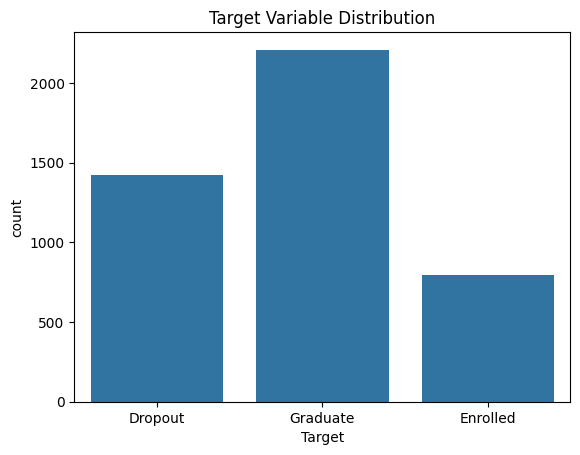

In [48]:
sea.countplot(x='Target', data = dataframe)
plt.title('Target Variable Distribution')
plt.show()

We should also consider the correlation between numerical variables. Let's check it out

In [57]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


def correlation_ratio(categorical, continuous):
    categories = categorical.unique()
    group_means = [continuous[categorical == cat].mean() for cat in categories]
    overall_mean = continuous.mean()
    numerator = sum([(mean - overall_mean)**2 * len(categorical[categorical == cat]) for cat, mean in zip(categories, group_means)])
    denominator = sum((continuous - overall_mean)**2)
    return np.sqrt(numerator / denominator) if denominator != 0 else 0

continous_features = ["Unemployment rate", "Inflation rate", "GDP", "Previous qualification (grade)", "Admission grade"]

get_columns = dataframe.select_dtypes(include=['number']).columns

continous_coluns = []
non_continous_coluns = []

for col in get_columns:
    if col in continous_features:
        continous_coluns.append(col)
    else:
        non_continous_coluns.append(col)

num_cols = len(continous_coluns) + len(non_continous_coluns)
all_cols = continous_coluns+non_continous_coluns

correlation_matrix = pd.DataFrame(index=all_cols, columns=all_cols, dtype=float)

for x in all_cols:
    for y in all_cols:
        if x in continous_coluns and y in continous_coluns:
            # Pearson for continuous-continuous
            correlation_matrix.loc[x, y] = dataframe[x].corr(dataframe[y])
        elif x in non_continous_coluns and y in non_continous_coluns:
            # Cramer's V for categorical-categorical
            correlation_matrix.loc[x, y] = cramers_v(dataframe[x], dataframe[y])
        else:
            # Correlation Ratio for mixed
            if x in continous_coluns:
                correlation_matrix.loc[x, y] = correlation_ratio(dataframe[y], dataframe[x])
            else:
                correlation_matrix.loc[x, y] = correlation_ratio(dataframe[x], dataframe[y])
  


plt.figure(figsize=(16, 10))
sea.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Heatmap of Numerical Variables')
plt.show()

NameError: name 'chi2_contingency' is not defined

However, this does not look good, we can't interpret it. Let's put a trehshold, so that only varaibles above the threshold are considered and shown.

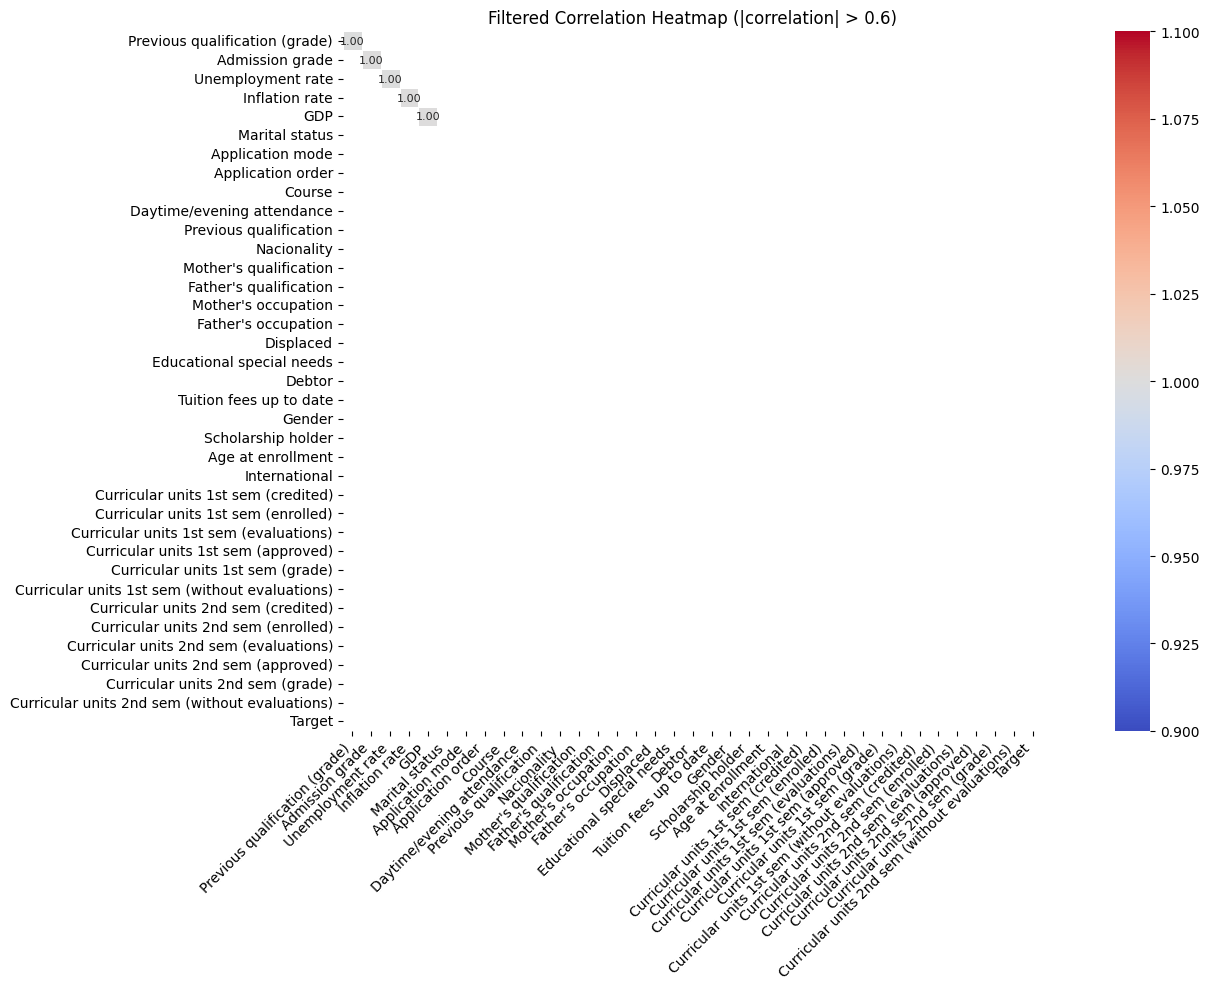

In [58]:
threshold = 0.6
mask = (abs(correlation_matrix) < threshold)

plt.figure(figsize=(16, 10))
sea.heatmap(correlation_matrix.mask(mask), annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 8}, square=True, linewidths=0.5)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title(f'Filtered Correlation Heatmap (|correlation| > {threshold})')
plt.tight_layout()
plt.show()

We wanna see the correlation between our variables and our target variable, however, our target is a string, so will have to encode it. After encoding our target variable we will set our X and Y axis.

In [50]:
le = LabelEncoder()

dataframe['Target'] = le.fit_transform(dataframe['Target'])

x_axis = dataframe.drop('Target', axis=1)
y_axis = dataframe['Target']

Since our target is now encoded we can check the correlation between varaibles and the target.

In [ ]:
target_relation = pd.DataFrame(index=all_cols, columns=['Association'], dtype=float)

for col in all_cols:
    if col in continous_coluns:
        target_relation.loc[col, 'Association'] = correlation_ratio(dataframe['Target'], dataframe[col])
    else:
        target_relation.loc[col, 'Association'] = cramers_v(dataframe[col], dataframe['Target'])

strong_correlations = target_relation[target_relation['Association'].abs() > 0.4].copy()

plt.figure(figsize=(16, 10))
sea.barplot(x=strong_correlations['Association'], y=strong_correlations.index, palette='coolwarm', hue=strong_correlations.index, legend=False)
plt.title(f'Features with Correlation |r| > 0,4 to Target')
plt.xlabel('Correlation with Target')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

NameError: name 'chi2_contingency' is not defined

As we can see, Tuition fees up to date, Curricular units 1nd sem (approved) and Curricular units 2nd sem (approved) are the most impactant features in relation with the Target. Now we split our data between training and testing.

In [59]:
x_train, x_test, y_train, y_test = train_test_split(x_axis, y_axis, test_size=0.2, random_state=40, stratify=y_axis)

The next step is to train our first model which is a Decision Tree Classifier.

In [60]:
clf = DecisionTreeClassifier( 
    criterion='gini',        # 
    max_depth=5,             # limit tree depth of our tree in order to avoid overfitting
    min_samples_split=6,     # mininum number of samples to make a new internal node
    min_samples_leaf=6,      # mininum number of samples to make a new leaf node
    random_state=40)         

start_train_dt = time.time()
clf.fit(x_train , y_train)
end_train_dt = time.time()

We test our Decision Tree with the X axis test data.

In [61]:
start_test_dt = time.time()
y_pred_dt = clf.predict(x_test)
end_test_dt = time.time()

Finally we check wether our Decision Tree was sucessful or not and categorize it in several metrics.

Acuracy: 0.7638
Precision: 0.7588
Recall: 0.7638
F1-Score: 0.7459
Confusion Matrix:


Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.70      0.77       284
           1       0.60      0.34      0.43       159
           2       0.75      0.96      0.84       442

    accuracy                           0.76       885
   macro avg       0.74      0.67      0.68       885
weighted avg       0.76      0.76      0.75       885

Training time: 0.0652 seconds
Testing time: 0.0123 seconds


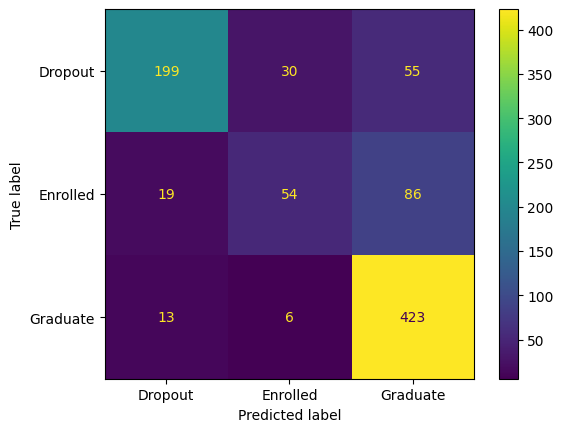

In [ ]:
accuracy_dt = skl.metrics.accuracy_score(y_test, y_pred_dt)
precision_dt = skl.metrics.precision_score(y_test, y_pred_dt, average="weighted", zero_division=0)
recal_dt = skl.metrics.recall_score(y_test, y_pred_dt, average="weighted", zero_division=0)
f1_score_dt = skl.metrics.f1_score(y_test, y_pred_dt, average="weighted", zero_division=0)
confusion_matrix_dt = skl.metrics.confusion_matrix(y_test,y_pred_dt)


print(f"Acuracy: {accuracy_dt:.4f}")
print(f"Precision: {precision_dt:.4f}")
print(f"Recall: {recal_dt:.4f}")
print(f"F1-Score: {f1_score_dt:.4f}")
labels = ['Dropout', 'Enrolled', 'Graduate']
print("Confusion Matrix:\n")
skl.metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_dt, display_labels=labels).plot()
print("\nClassification Report:\n")
print(skl.metrics.classification_report(y_test,y_pred_dt, zero_division=0))
print(f"Training time: {end_train_dt-start_train_dt:.4f} seconds")
print(f"Testing time: {end_test_dt-start_test_dt:.4f} seconds")

Here's the visual representation of the Decision Tree.

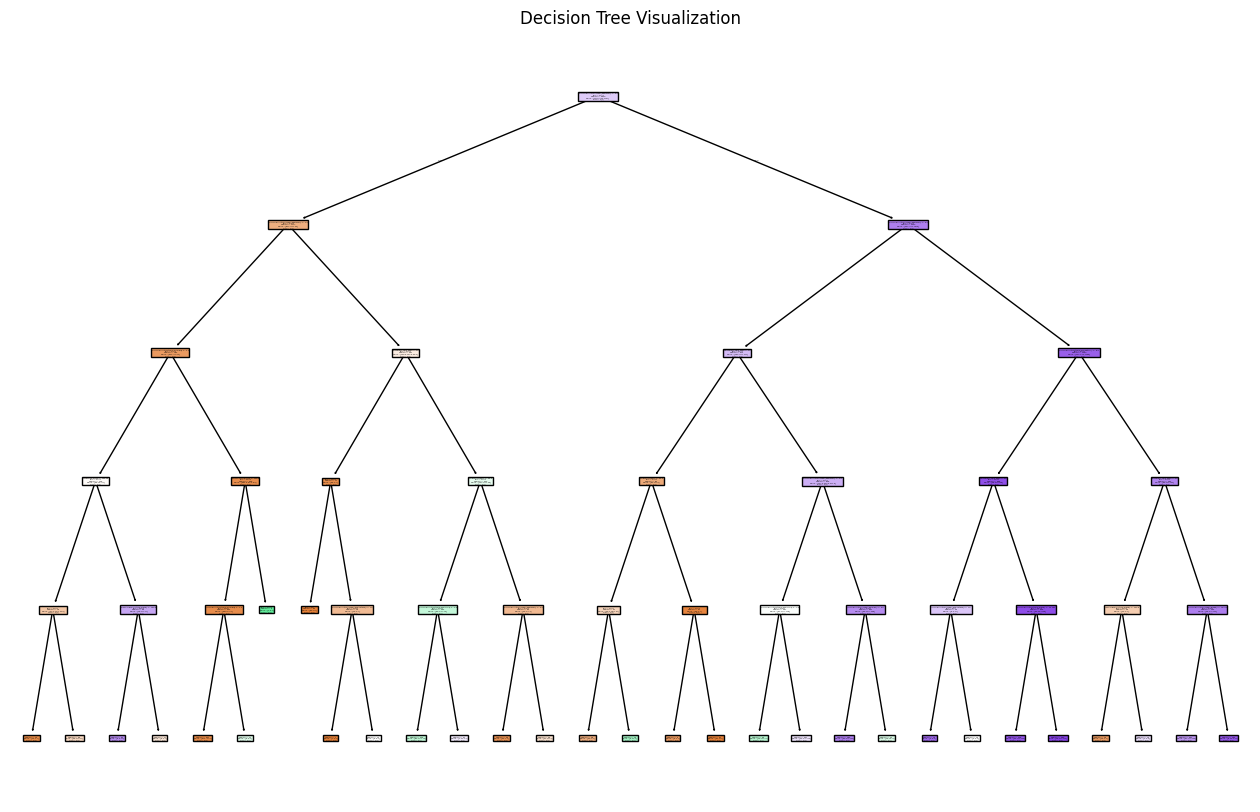

In [55]:
plt.figure(figsize=(16,10))
skl.tree.plot_tree(clf, filled=True, feature_names=x_axis.columns, class_names=True)
plt.title("Decision Tree Visualization")
plt.show()

The next step is to train our first model which is a Decision Tree Classifier.

In [56]:
clf = DecisionTreeClassifier(random_state=40)
start_train_dt = time.time()
clf.fit(x_train_scaled , y_train_resampled)
end_train_dt = time.time()

ValueError: Number of labels=5340 does not match number of samples=3539

We test our Decision Tree with the X axis test data.

In [ ]:
start_test_dt = time.time()
y_pred_dt = clf.predict(x_test_scaled)
end_test_dt = time.time()

Finally we check wether our Decision Tree was sucessful or not and categorize it in several metrics.

Acuracy: 0.6633
Precision: 0.6756
Recall: 0.6633
F1-Score: 0.6685
Confusion Matrix:


Classification Report:

              precision    recall  f1-score   support

           0       0.71      0.67      0.69       287
           1       0.39      0.46      0.42       169
           2       0.77      0.74      0.75       429

    accuracy                           0.66       885
   macro avg       0.62      0.62      0.62       885
weighted avg       0.68      0.66      0.67       885

Training time: 0.0864 seconds
Testing time: 0.0000 seconds


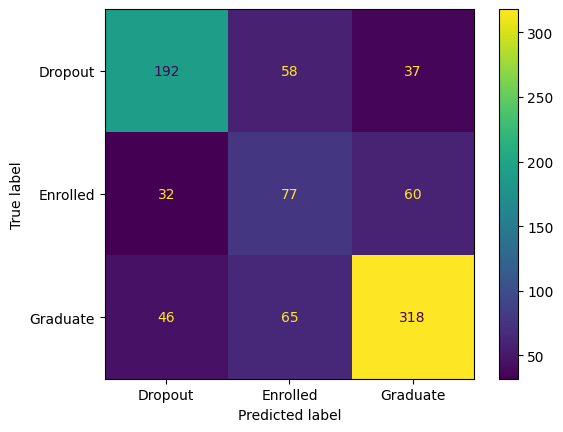

In [ ]:
accuracy_dt = skl.metrics.accuracy_score(y_test, y_pred_dt)
precision_dt = skl.metrics.precision_score(y_test, y_pred_dt, average="weighted", zero_division=0)
recal_dt = skl.metrics.recall_score(y_test, y_pred_dt, average="weighted", zero_division=0)
f1_score_dt = skl.metrics.f1_score(y_test, y_pred_dt, average="weighted", zero_division=0)
confusion_matrix_dt = skl.metrics.confusion_matrix(y_test,y_pred_dt)


print(f"Acuracy: {accuracy_dt:.4f}")
print(f"Precision: {precision_dt:.4f}")
print(f"Recall: {recal_dt:.4f}")
print(f"F1-Score: {f1_score_dt:.4f}")
labels = ['Dropout', 'Enrolled', 'Graduate']
print("Confusion Matrix:\n")
skl.metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_dt, display_labels=labels).plot()
print("\nClassification Report:\n")
print(skl.metrics.classification_report(y_test,y_pred_dt, zero_division=0))
print(f"Training time: {end_train_dt-start_train_dt:.4f} seconds")
print(f"Testing time: {end_test_dt-start_test_dt:.4f} seconds")



Here's the visual representation of the Decision Tree.

In [ ]:
plt.figure(figsize=(16,10))
skl.tree.plot_tree(clf, filled=True, feature_names=x_axis.columns, class_names=True)
plt.title("Decision Tree Visualization")
plt.show()

Now we will train our second model, Neural Networks. In this case, using SMOTENC helps us getting better results.

In [ ]:
cat_indices = [dataframe.columns.get_loc(x) for x in non_continous_coluns]
smote = SMOTENC(categorical_features=cat_indices, 
                random_state=40)


x_train_smoted, y_train_smoted = smote.fit_resample(x_train, y_train)

mlp = MLPClassifier(hidden_layer_sizes=(265,128,32),
                    activation='relu', 
                    solver='adam', 
                    batch_size=64,
                    max_iter=500,             #maximun number of iterations
                    learning_rate_init=0.001,
                    alpha=0.00005,
                    early_stopping=True,       #in order to avoid overfitting
                    random_state=40)            

start_train_nn = time.time()
mlp.fit(x_train_smoted , y_train_smoted)
end_train_nn = time.time()

We test our Neural Network algorithm with the X axis test data.

In [ ]:
start_test_nn = time.time()
y_pred_nn = mlp.predict(x_test)
end_test_nn = time.time()

Finally we check wether our Neural Network algorithm was sucessful or not and categorize it in several metrics.

In [ ]:
accuracy_nn = skl.metrics.accuracy_score(y_test, y_pred_nn)
precision_nn = skl.metrics.precision_score(y_test, y_pred_nn, average="weighted", zero_division=0)
recal_nn = skl.metrics.recall_score(y_test, y_pred_nn, average="weighted", zero_division=0)
f1_score_nn = skl.metrics.f1_score(y_test, y_pred_nn, average="weighted", zero_division=0)
confusion_matrix_nn = skl.metrics.confusion_matrix(y_test,y_pred_nn)


print(f"Acuracy: {accuracy_nn:.4f}")
print(f"Precision: {precision_nn:.4f}")
print(f"Recall: {recal_nn:.4f}")
print(f"F1-Score: {f1_score_nn:.4f}")
labels = ['Dropout', 'Enrolled', 'Graduate']
print("Confusion Matrix:\n")
skl.metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_nn, display_labels=labels).plot()
print("\nClassification Report:\n")
print(skl.metrics.classification_report(y_test,y_pred_nn, zero_division=0))
print(f"Training time: {end_train_nn-start_train_nn:.4f} seconds")
print(f"Testing time: {end_test_nn-start_test_nn:.4f} seconds")
#88 36 84

Well..Neural Networks are quite sensitive to class inbalance, so we can say that our results, even though are far from what we wanted are not as far from the expected as they look.

Acuracy: 0.7435
Precision: 0.7453
Recall: 0.7435
F1-Score: 0.7429
Confusion Matrix:


Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.72      0.77       287
           1       0.48      0.49      0.49       169
           2       0.80      0.86      0.83       429

    accuracy                           0.74       885
   macro avg       0.70      0.69      0.69       885
weighted avg       0.75      0.74      0.74       885

Training time: 2.9478 seconds
Testing time: 0.0811 seconds


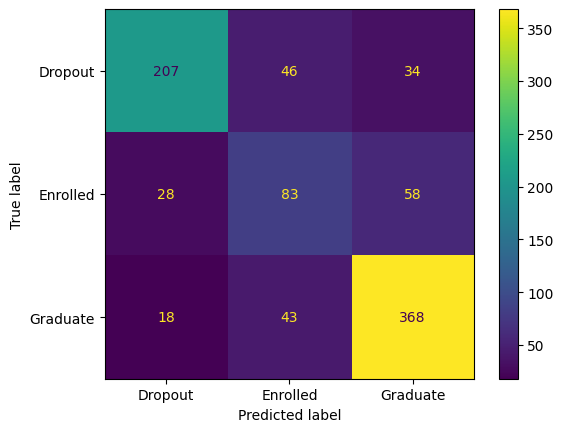

In [ ]:
import joblib

# Caminhos dos ficheiros
x_train_path = "x_train_scaled.pkl"
y_train_path = "y_train_resampled.pkl"
x_test_path = "x_test_scaled.pkl"
y_test_path = "y_test.pkl"

# Carregar os dados
x_train_scaled = joblib.load(x_train_path)
y_train_resampled = joblib.load(y_train_path)
x_test_scaled = joblib.load(x_test_path)
y_test = joblib.load(y_test_path)

# Verificar as dimensões carregadas
x_train_scaled.shape, y_train_resampled.shape, x_test_scaled.shape, y_test.shape

In [ ]:
# Reimportar bibliotecas após reset do ambiente
import joblib

# Caminhos dos ficheiros
x_train_path = "x_train_scaled.pkl"
y_train_path = "y_train_resampled.pkl"
x_test_path = "x_test_scaled.pkl"
y_test_path = "y_test.pkl"

# Carregar os dados
x_train_scaled = joblib.load(x_train_path)
y_train_resampled = joblib.load(y_train_path)
x_test_scaled = joblib.load(x_test_path)
y_test = joblib.load(y_test_path)

# Verificar as dimensões carregadas
x_train_scaled.shape, y_train_resampled.shape, x_test_scaled.shape, y_test.shape

((5340, 36), (5340,), (885, 36), (885,))

Vamos treinar e avaliar o modelo SVM

Métricas usadas:
1. Accuracy
 O que é: Proporção de previsões corretas em relação ao total de exemplos.

 Fórmula:

Accuracy = Número de previsões corretas/Total de exemplos
 
-> Neste caso:
accuracy_score(y_test, y_pred_svm)
 - Acerta quando o modelo previu exatamente o rótulo real (ex: previu "graduate" e o aluno realmente graduou).

2. Precision (weighted)
 O que é: Mede, entre as previsões positivas feitas, quantas estavam certas.

 Fórmula por classe 

Precision𝑖 = 𝑇𝑃𝑖 / 𝑇𝑃𝑖 + 𝐹𝑃𝑖
​
 
 TP = verdadeiros positivos, FP = falsos positivos

 Weighted = média ponderada pela quantidade de amostras de cada classe:

Precision weighted = ∑𝑖 ( 𝑛𝑖/𝑁 × Precision𝑖 )

-> Usamos:
precision_score(y_test, y_pred_svm, average="weighted")

3. Recall (weighted)
 O que é: Mede, entre os casos que realmente pertencem a uma classe, quantos foram corretamente identificados.

 Fórmula por classe 

Recall𝑖 = 𝑇𝑃𝑖 / 𝑇𝑃𝑖 + 𝐹𝑁𝑖 ​
 
 FN = falsos negativos

-> Também com média ponderada:
recall_score(y_test, y_pred_svm, average="weighted")

4. F1-score (weighted)
 O que é: Média harmónica entre precisão e recall.

 Fórmula por classe 
𝐹1𝑖 = 2 × Precision𝑖 ⋅ Recall𝑖 / Precision𝑖 + Recall𝑖

-> E a média ponderada:
f1_score(y_test, y_pred_svm, average="weighted")

 Por que usar "weighted"?
Porque o nosso dataset é desbalanceado (mais alunos "Graduate" do que "Enrolled", por exemplo).
A média ponderada evita que classes maiores dominem o resultado.

5. Confusion Matrix
 O que é: Mostra como cada classe foi classificada.

                            | Previsto Dropout (0)	| Previsto Enrolled (1)  |	Previsto Graduate (2)
        Real Dropout (0)	|        TP₀	        |        FP₁	         |      FP₂              
        Real Enrolled (1)	|        FN₁	        |        TP₁	         |      FP₃              
        Real Graduate (2)	|        FN₂	        |        FN₃	         |      TP₂              

-> Exemplo:
confusion_matrix(y_test, y_pred_svm)

Accuracy: 0.7288
Precision: 0.7458
Recall: 0.7288
F1-Score: 0.7319
Confusion Matrix:

Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.67      0.75       287
           1       0.45      0.53      0.49       169
           2       0.78      0.85      0.82       429

    accuracy                           0.73       885
   macro avg       0.70      0.68      0.68       885
weighted avg       0.75      0.73      0.73       885

Training time: 1.0385 seconds
Testing time: 0.4279 seconds


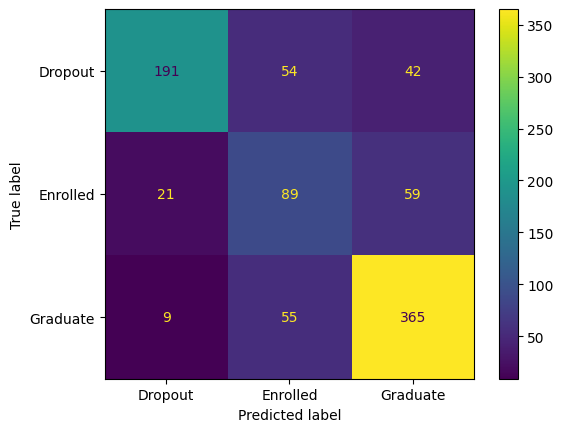

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, ConfusionMatrixDisplay
)
import time

# 1. Criar e treinar o modelo
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=40)

start_train_svm = time.time()
svm_model.fit(x_train_scaled, y_train_resampled)
end_train_svm = time.time()
    
# 2. Fazer previsões no conjunto de teste
start_test_svm = time.time()
y_pred_svm = svm_model.predict(x_test_scaled)
end_test_svm = time.time()

# 3. Calcular métricas de avaliação
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm, average="weighted", zero_division=0)
recall_svm = recall_score(y_test, y_pred_svm, average="weighted", zero_division=0)
f1_score_svm = f1_score(y_test, y_pred_svm, average="weighted", zero_division=0)
confusion_matrix_svm = confusion_matrix(y_test, y_pred_svm)

# 4. Mostrar os resultados
print(f"Accuracy: {accuracy_svm:.4f}")
print(f"Precision: {precision_svm:.4f}")
print(f"Recall: {recall_svm:.4f}")
print(f"F1-Score: {f1_score_svm:.4f}")
print("Confusion Matrix:")
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_svm, display_labels=['Dropout', 'Enrolled', 'Graduate']).plot()
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_svm, zero_division=0))

print(f"Training time: {end_train_svm - start_train_svm:.4f} seconds")
print(f"Testing time: {end_test_svm - start_test_svm:.4f} seconds")


Vamos experimentar com pesos reajustados.

Como o SVM calcula os pesos com class_weight='balanced'?
Para cada classe 𝑐, o peso é calculado como:

𝑤𝑐 = 𝑛samples / 𝑛classes × 𝑛𝑐

Onde:
𝑛samples​ = número total de exemplos no treino
𝑛𝑐 = número de exemplos da classe 𝑐
𝑛classes = número total de classes


=== SVM Normal (sem SMOTE) ===
Accuracy: 0.7616
Precision: 0.7430
Recall: 0.7616
F1-Score: 0.7429

Classification Report:

              precision    recall  f1-score   support

           0       0.81      0.74      0.77       284
           1       0.52      0.30      0.38       159
           2       0.78      0.94      0.85       442

    accuracy                           0.76       885
   macro avg       0.70      0.66      0.67       885
weighted avg       0.74      0.76      0.74       885

Training time: 0.4859 seconds
Testing time: 0.2031 seconds

=== SVM com Pesos Balanceados (sem SMOTE) ===
Accuracy: 0.7333
Precision: 0.7675
Recall: 0.7333
F1-Score: 0.7447

Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.70      0.76       284
           1       0.43      0.62      0.51       159
           2       0.84      0.80      0.82       442

    accuracy                           0.73       885
   macro avg       0.70  

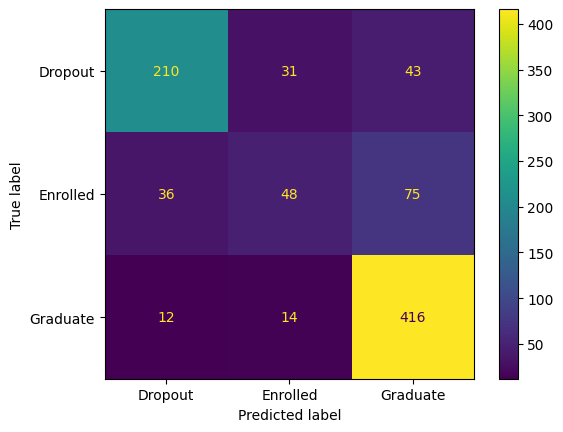

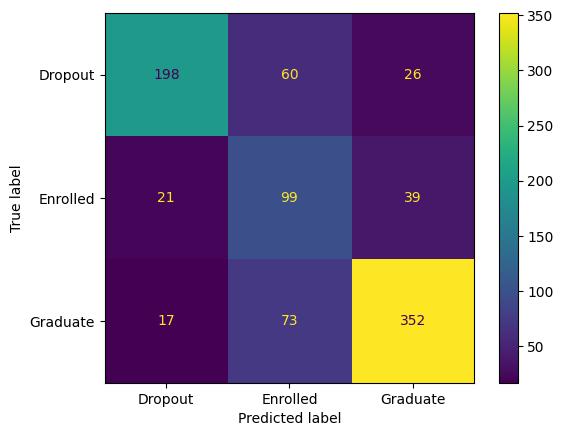

In [ ]:
# Comparação entre SVM normal e SVM com class_weight='balanced' (sem SMOTE)

from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, ConfusionMatrixDisplay
)
import time
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Recarregar o dataset original
df = pd.read_csv("data.csv")
le = LabelEncoder()
df['Target'] = le.fit_transform(df['Target'])
X = df.drop("Target", axis=1)
y = df["Target"]

# Dividir treino/teste SEM SMOTE
x_train_orig, x_test_orig, y_train_orig, y_test_orig = train_test_split(
    X, y, test_size=0.2, random_state=40, stratify=y)

# Normalizar
scaler = StandardScaler()
x_train_scaled_orig = scaler.fit_transform(x_train_orig)
x_test_scaled_orig = scaler.transform(x_test_orig)

# Modelo 1: SVM normal
svm_norm = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=40)
start_train_norm = time.time()
svm_norm.fit(x_train_scaled_orig, y_train_orig)
end_train_norm = time.time()
start_test_norm = time.time()
y_pred_norm = svm_norm.predict(x_test_scaled_orig)
end_test_norm = time.time()

# Modelo 2: SVM com pesos balanceados
svm_bal = SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced', random_state=40)
start_train_bal = time.time()
svm_bal.fit(x_train_scaled_orig, y_train_orig)
end_train_bal = time.time()
start_test_bal = time.time()
y_pred_bal = svm_bal.predict(x_test_scaled_orig)
end_test_bal = time.time()

# Mostrar resultados comparativos
def show_results(name, y_true, y_pred, train_t, test_t):
    print(f"\n=== {name} ===")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred, average='weighted'):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred, average='weighted'):.4f}")
    print(f"F1-Score: {f1_score(y_true, y_pred, average='weighted'):.4f}")
    ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels=['Dropout', 'Enrolled', 'Graduate']).plot()
    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, zero_division=0))
    print(f"Training time: {train_t:.4f} seconds")
    print(f"Testing time: {test_t:.4f} seconds")

# Resultados
show_results("SVM Normal (sem SMOTE)", y_test_orig, y_pred_norm, end_train_norm - start_train_norm, end_test_norm - start_test_norm)
show_results("SVM com Pesos Balanceados (sem SMOTE)", y_test_orig, y_pred_bal, end_train_bal - start_train_bal, end_test_bal - start_test_bal)


Vamos agora testar com pesos manualmente alterados.

 - Estratégias comuns:

        
         Estratégia	                   |        Peso usado	     |       Justificação             |
         Priorizar classe minoritária	   |        {1: 3.0}	     |  Enrolled teve baixo recall    |
         Penalizar Dropout mais	   |        {0: 2.0}	     | Foco institucional na retenção |
         Equilibrar sem overfit	   |   {0:1.2, 1:1.8, 2:1.0} |	Mais fino que o balanced      |

# Justificação dos Pesos Manuais
Após aplicar `class_weight='balanced'`, decidimos experimentar pesos definidos manualmente:
- Classe 1 (“Enrolled”) foi priorizada com peso 3.0, por ser minoritária e ter baixo desempenho.
- Classe 0 (“Dropout”) recebeu peso 1.5, também importante no contexto educacional.
- Classe 2 (“Graduate”) manteve o peso base (1.0).

Este ajuste melhorou a F1-score geral e aumentou o recall da classe Enrolled.

=== SVM com Pesos Manuais ===
Accuracy: 0.7356
Precision: 0.7722
Recall: 0.7356
F1-Score: 0.7478

Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.70      0.76       284
           1       0.42      0.63      0.51       159
           2       0.86      0.80      0.83       442

    accuracy                           0.74       885
   macro avg       0.71      0.71      0.70       885
weighted avg       0.77      0.74      0.75       885

Training time: 0.5231 seconds
Testing time: 0.2471 seconds


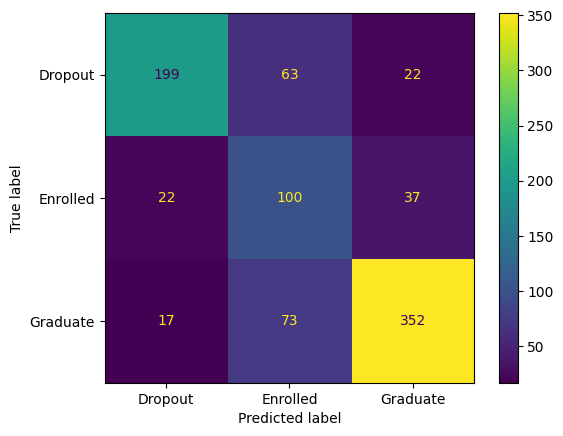

In [ ]:
# Recarregar o dataset
df = pd.read_csv("data.csv")
le = LabelEncoder()
df["Target"] = le.fit_transform(df["Target"])
X = df.drop("Target", axis=1)
y = df["Target"]

# Dividir e normalizar
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40, stratify=y)
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Treinar SVM com pesos manuais
custom_weights = {0: 1.5, 1: 3.0, 2: 1.0}
svm_custom = SVC(kernel='rbf', C=1.0, gamma='scale', class_weight=custom_weights, random_state=40)

start_train_custom = time.time()
svm_custom.fit(x_train_scaled, y_train)
end_train_custom = time.time()

start_test_custom = time.time()
y_pred_custom = svm_custom.predict(x_test_scaled)
end_test_custom = time.time()

# Avaliação
accuracy_custom = accuracy_score(y_test, y_pred_custom)
precision_custom = precision_score(y_test, y_pred_custom, average="weighted", zero_division=0)
recall_custom = recall_score(y_test, y_pred_custom, average="weighted", zero_division=0)
f1_custom = f1_score(y_test, y_pred_custom, average="weighted", zero_division=0)

print("=== SVM com Pesos Manuais ===")
print(f"Accuracy: {accuracy_custom:.4f}")
print(f"Precision: {precision_custom:.4f}")
print(f"Recall: {recall_custom:.4f}")
print(f"F1-Score: {f1_custom:.4f}")
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_custom), display_labels=['Dropout', 'Enrolled', 'Graduate']).plot()
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_custom, zero_division=0))
print(f"Training time: {end_train_custom - start_train_custom:.4f} seconds")
print(f"Testing time: {end_test_custom - start_test_custom:.4f} seconds")


Vamos comparar resultados